In [2]:
%load_ext autoreload
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")

import jax.numpy as jnp
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd
    
import utils
import plot
import distributions
import models
import flows

key = random.PRNGKey(0)

from functools import partial
import kernels

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets
sns.set(style='white')

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Bayesian logistic regression using Tensorflow Probability
(Setup stolen from the TFP tutorial notebook)

In [3]:
iris = datasets.load_iris()
features, labels = iris['data'], iris['target']

num_features = features.shape[-1]
num_classes = len(iris.target_names)

In [4]:
len(labels)

150

We can define the model using `tfd.JointDistributionCoroutine`. We'll put standard normal priors on both the weights and the bias term then write a `target_log_prob` function that pins the sampled labels to the data.

In [7]:
Root = tfd.JointDistributionCoroutine.Root
def model():
    w = yield Root(tfd.Sample(tfd.Normal(0., 1.),
                            sample_shape=(num_features, num_classes), name="w"))
    b = yield Root(tfd.Sample(tfd.Normal(0., 1.), sample_shape=(num_classes,), name="b"))
    logits = jnp.dot(features, w) + b
    _ = yield tfd.Independent(tfd.Categorical(logits=logits), reinterpreted_batch_ndims=1, name="labels") # this is why log_prob(sample) doesnt work: the batch dims are switched


dist = tfd.JointDistributionCoroutine(model)
def target_log_prob(*params):
    return dist.log_prob(params + (labels,))

In [8]:
# for intuition on how the model works:
key, subkey = random.split(key)
w = random.normal(subkey, shape=(num_features, num_classes))
key, subkey = random.split(key)
b = random.normal(subkey, shape=(num_classes, ))

dist.log_prob((w, b, labels))

DeviceArray(-595.33276, dtype=float32)

We sample from `dist` to produce an initial state for MCMC. We can then define a function that takes in a random key and an initial state, and produces 500 samples from a No-U-Turn-Sampler (NUTS). Note that we can use JAX transformations like `jit` to compile our NUTS sampler using XLA.

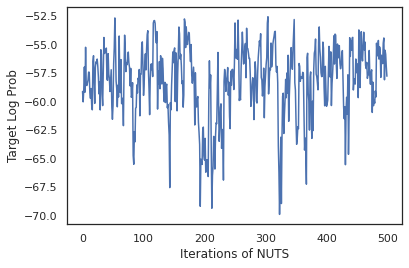

In [10]:
init_key, sample_key = random.split(random.PRNGKey(0))
init_params = tuple(dist.sample(seed=init_key)[:-1])

@jit
def run_nuts_chain(key, state):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
    return tfp.mcmc.sample_chain(500,
      current_state=state,
      kernel=kernel,
      trace_fn=lambda _, results: results.target_log_prob,
      num_burnin_steps=500, # CHANGED
      seed=key)

states, log_probs = run_nuts_chain(sample_key, init_params)
plt.figure()
plt.plot(log_probs)
plt.ylabel('Target Log Prob')
plt.xlabel('Iterations of NUTS')
plt.show()

Let's use our samples to perform Bayesian model averaging (BMA) by averaging the predicted probabilies of each set of weights.

First let's write a function that for a given set of parameters will produce the probabilities over each class. We can use `dist.sample_distributions` to obtain the final distribution in the model.

In [15]:
params = dist.sample(seed=key)
dists, _ = dist.sample_distributions(seed=random.PRNGKey(0),
                                   value=params + (None,))

In [22]:
dists[-1].distribution.probs_parameter().shape

(150, 3)

In [ ]:
dists[-1].distribution.probs_parameter

In [11]:
def classifier_probs(params):
    dists, _ = dist.sample_distributions(seed=random.PRNGKey(0),
                                       value=params + (None,))
    return dists[-1].distribution.probs_parameter() # ie pdf of categorical(logit)

We can `vmap(classifier_probs)` over the set of samples to get the predicted class probabilities for each of our samples. We then compute the average accuracy across each sample, and the accuracy from Bayesian model averaging.

In [12]:
all_probs = jit(vmap(classifier_probs))(states)
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1) == labels))

Average accuracy: 0.96952
BMA accuracy: 0.98


Looks like BMA reduces our error rate by almost a third!

# We can do the same thing with Langevin dynamics

In [16]:
kernel = tfp.mcmc.UncalibratedLangevin(target_log_prob, 1e-3)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:327: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn('supplied `TransitionKernel` is not calibrated. Markov '


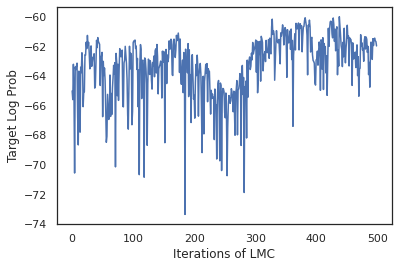

In [17]:
@jit
def run_lmc_chain(key, state):
    kernel = tfp.mcmc.UncalibratedLangevin(target_log_prob, 1e-3)
    return tfp.mcmc.sample_chain(500,
      current_state=state,
      kernel=kernel,
      trace_fn=lambda _, results: results.target_log_prob,
      num_burnin_steps=500, # CHANGED
      seed=key)

states, log_probs = run_lmc_chain(sample_key, init_params)
plt.figure()
plt.plot(log_probs)
plt.ylabel('Target Log Prob')
plt.xlabel('Iterations of LMC')
plt.show()

# Use `vmap` to run multiple chains

In [18]:
n_particles = 500
keys = random.split(key, n_particles)
init_batch = dist.sample(n_particles, seed=key)[:-1]

# NUTS
nuts_states, nuts_logp = vmap(run_nuts_chain)(keys, init_batch)
final_nuts_states = [param[:, -1, :] for param in nuts_states]

# LMC
lmc_states, lmc_logp = vmap(run_lmc_chain)(keys, init_batch)
final_lmc_states = [param[:, -1, :] for param in lmc_states]

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/tensorflow_probability/substrates/jax/mcmc/sample.py:327: UserWarning: supplied `TransitionKernel` is not calibrated. Markov chain may not converge to intended target distribution.
  warnings.warn('supplied `TransitionKernel` is not calibrated. Markov '


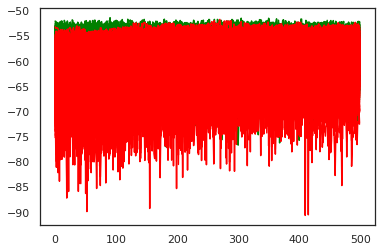

In [19]:
plt.plot(np.rollaxis(nuts_logp, 1), color="green", label="NUTS")
plt.plot(np.rollaxis(lmc_logp, 1), color="red", label="LMC");
# plt.legend()

# Now run the same inference with my methods

We can ravel (flatten) and unravel parameters like so:

In [21]:
params = dist.sample(seed=key)[:-1]
params_flat, unravel = jax.flatten_util.ravel_pytree(params)
# unravel(params_flat) == params

batch = dist.sample(3, seed=key)[:-1]
batch_flat = batch_ravel(batch)
# batch == batch_unravel(batch_flat)

In [20]:
def logp(params_flat):
    return target_log_prob(*unravel(params_flat))

def ravel(params):
    flat, unravel = jax.flatten_util.ravel_pytree(params)
    return flat

def batch_ravel(batch):
    return vmap(ravel)(batch)

def batch_unravel(batch_flat):
    return vmap(unravel)(batch_flat)

In [22]:
def run_svgd(key, init_batch):
    """init_batch is a batch of initial samples / particles."""
    init_batch = batch_ravel(init_batch)
    key, keya, keyb = random.split(key, 3)
    kernel_gradient = models.KernelGradient(target_logp=logp,
                                            key=keya)
    gradient = partial(kernel_gradient.gradient, scaled=True) # scale to match lambda_reg

    svgd_particles = models.Particles(key=keyb,
                                      gradient=gradient,
                                      init_samples=init_batch,
                                      learning_rate=1e-3,
                                      num_groups=1)
    for _ in range(500):
        svgd_particles.step(None)
    return batch_unravel(svgd_particles.particles.training), kernel_gradient, svgd_particles

In [23]:
def run_lmc(key, init_batch):
    """init_batch is a batch of initial samples / particles."""
    init_batch = batch_ravel(init_batch)
    key, keya, keyb = random.split(key, 3)
    energy_gradient = models.EnergyGradient(target_logp=logp, key=keya)

    lmc_particles = models.Particles(key=keyb,
                                     gradient=energy_gradient.gradient,
                                     init_samples=init_batch,
                                     learning_rate=1e-3,
                                     num_groups=1,
                                     noise_level=1.)
    for _ in range(500):
        lmc_particles.step(None)
    return batch_unravel(lmc_particles.particles.training), energy_gradient, lmc_particles

In [24]:
def run_neural_svgd(key, init_batch):
    """init_batch is a batch of initial samples / particles."""
    init_batch = batch_ravel(init_batch)
    key, keya, keyb = random.split(key, 3)
    learner = models.SDLearner(target_logp=logp, target_dim=init_batch.shape[1], key=keya)

    particles = models.Particles(key=keyb,
                                 gradient=learner.gradient,
                                 init_samples=init_batch,
                                 learning_rate=1e-3,
                                 num_groups=2)
    next_batch = partial(particles.next_batch, batch_size=None)
    for _ in range(1000):
        key, subkey = random.split(key)
        learner.train(next_batch, key=subkey, n_steps=1)
        particles.step(learner.get_params())
    return batch_unravel(particles.particles.training), learner, particles

In [26]:
init_batch = dist.sample(n_particles, seed=key)[:-1]
svgd_samples, gradient, particles = run_svgd(key, init_batch)
lmc_samples, lmc_gradient, lmc_particles = run_lmc(key, init_batch)
neural_samples, neural_gradient, neural_particles = run_neural_svgd(key, init_batch)

In [42]:
all_probs.shape

(100, 150, 3)

In [27]:
# Neural samples
all_probs = jit(vmap(classifier_probs))(neural_samples)
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1) == labels))

Average accuracy: 0.92461336
BMA accuracy: 0.98


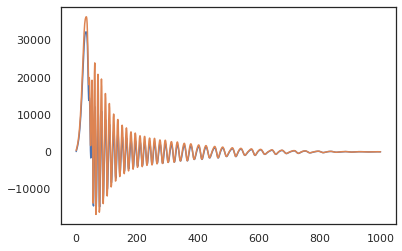

In [28]:
plt.plot(neural_gradient.rundata["training_sd"])
plt.plot(neural_gradient.rundata["validation_sd"])

In [29]:
# NUTS samples
all_probs = jit(vmap(classifier_probs))(states)
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1) == labels))

Average accuracy: 0.9468267
BMA accuracy: 0.96666664


In [30]:
# Parallel NUTS final state
all_probs = jit(vmap(classifier_probs))(tuple(final_nuts_states))
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1) == labels))

Average accuracy: 0.96848
BMA accuracy: 0.9866667


In [31]:
# Parallel LMC (TFP) samples
all_probs = jit(vmap(classifier_probs))(tuple(final_lmc_states))
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1) == labels))

Average accuracy: 0.95966667
BMA accuracy: 0.98


In [32]:
# Parallel LMC (Lauro) samples
all_probs = jit(vmap(classifier_probs))(lmc_samples)
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1) == labels))

Average accuracy: 0.9368
BMA accuracy: 0.98


In [33]:
# SVGD samples
all_probs = jit(vmap(classifier_probs))(svgd_samples)
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1) == labels))

Average accuracy: 0.9509467
BMA accuracy: 0.98


In [34]:
# random samples
all_probs = jit(vmap(classifier_probs))(tuple(dist.sample(100, seed=key)[:-1]))
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1) == labels))

Average accuracy: 0.32633334
BMA accuracy: 0.33333334


# Study difference between methods

In [35]:
# remember, we have final states of vmapped tfp samplers:
w_nuts, b_nuts = final_nuts_states # all shaped (100, 3)
w_lmc, b_lmc = final_lmc_states

# as well as those from my methods
w_svgd, b_svgd = svgd_samples
w_lmc_l, b_lmc_l = lmc_samples
w_neural, b_neural = neural_samples

Let's plot the samples from the bias term:

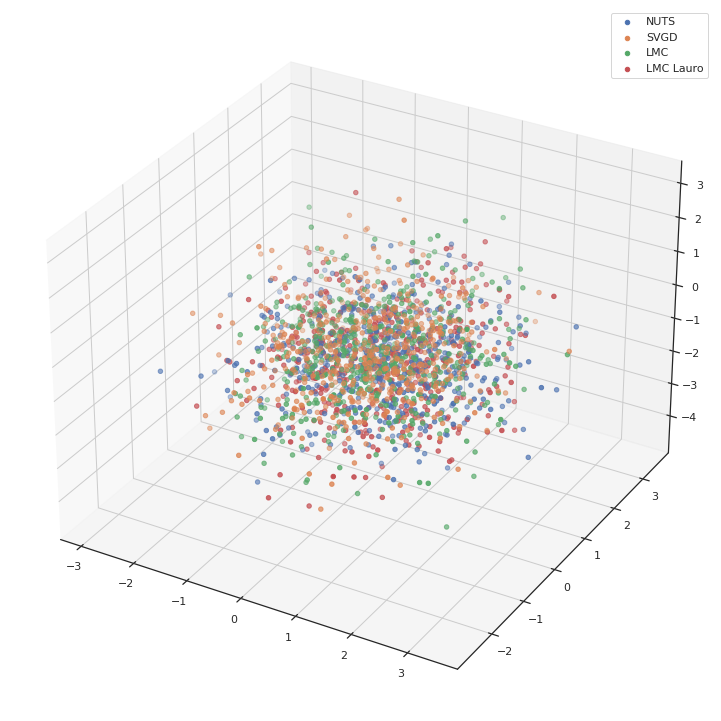

In [36]:
%matplotlib inline
fig = plt.figure(figsize=[13, 13])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*np.rollaxis(b_nuts, 1), label="NUTS")
ax.scatter(*np.rollaxis(b_svgd, 1), label="SVGD")
ax.scatter(*np.rollaxis(b_lmc, 1), label="LMC")
ax.scatter(*np.rollaxis(b_lmc_l, 1), label="LMC Lauro")
ax.legend()

Now plot the terms associated with petal width and breadth

# Compare numerically

In [37]:
def e_score(samples):
    """Should return c, where true_logp = logp + c"""
    return np.mean(vmap(target_log_prob)(*samples))

In [38]:
sample_categories = [
    final_lmc_states,
    final_nuts_states,
    svgd_samples,
    lmc_samples,
]

In [39]:
for sample in sample_categories:
    print(e_score(sample))

-59.1514
-58.147335
-63.340996
-62.63813


In [40]:
svgd_samples_flat = batch_ravel(svgd_samples)

In [41]:
svgd_samples_flat.shape

(500, 15)